In [1]:
#! /usr/bin/env python                                                                                            
# Run PSFEx for a set of exposures, including making any necessarily input files.                                 
# It also logs errors into a psf blacklist file.                                                                  
# Functions stolen from:                                                                                          
# https://github.com/rmjarvis/DESWL/blob/master/psf/run_piff.py                                                   
# Currently NO RESERVE STARS                                                                                      
# Probably lots of extraneous parameters and flags as well...                                                     
from __future__ import print_function
import os
import sys
import shutil
import logging
import datetime
import traceback
import numpy as np
import copy
import glob
import time
import fitsio
#import pixmappy
import pandas
import galsim
import galsim.des
import piff
import ngmix
from astropy.io import fits
import wget
from astropy.wcs import WCS

import matplotlib
#matplotlib.use('Agg') # needs to be done before import pyplot                                                    
import matplotlib.pyplot as plt

In [2]:
# Don't skip columns in describe output  (default is 20, which is a bit too small)                                
pandas.options.display.max_columns = 200 

# Define the parameters for the blacklist                                                                         
# AC note:  a lot of these settings are not really used for the deep fields                                       
# currently...!   

# How many stars are too few or too many? 
FEW_STARS = 25
MANY_STARS_FRAC = 0.3
# How high is a high FWHM?  3.6 arcsec / 0.26 arcsec/pixel = 13.8 pixels                                          
#HIGH_FWHM = 13.8                                                                                                 
HIGH_FWHM = 3.6  # (We switched to measuring this in arcsec)                                                      
NSIG_T_OUTLIER = 4   # How many sigma for a chip to be an outlier in <T>.                                         

# Not copying flag vals for blacklist and psf catalog...                                                          
rng = galsim.BaseDeviate(1234)
MAX_CENTROID_SHIFT = 1.0
NOT_USED = 1
BAD_MEASUREMENT = 2
CENTROID_SHIFT = 4
OUTLIER = 8
FAILURE = 32
RESERVED = 64
NOT_STAR = 128
BLACK_FLAG_FACTOR = 512 # blacklist flags are this times the original exposure blacklist flag                     
# blacklist flags go up to 64,       

# Not copying array to convert ccdnum to detpos (this may or may not                                              
# be important)     

In [3]:
#put the stars data into a dataframe 

def read_psfex_stars(star_file, cat_file, magzp, logger): #combination of read findstars and read_image_header in MJ script
    """Read the PSFEx star selection                                                                              
    """
    if not os.path.exists(star_file):
        return None

    # Read the output and make a DataFrome with the contents                                                      
    data = fitsio.read(star_file, ext=2)
    data = data.astype(data.dtype.newbyteorder('='))
    flags_psf = data['FLAGS_PSF']
    source_id = data['SOURCE_NUMBER']
    x_im = data['X_IMAGE']
    y_im = data['Y_IMAGE']
    df = pandas.DataFrame(data={'SOURCE_NUMBER':source_id, 'X_IMAGE':x_im,
                          'Y_IMAGE':y_im, 'FLAGS_PSF':flags_psf})

    ntot = len(df)
    nstars = df['FLAGS_PSF'].sum()
    print('   found %d stars',ntot,nstars)
    logger.info('   found %d stars',nstars)
    #is_star = df['FLAGS_PSF'] == 1
    #print
    #print('   found %d good stars', len(is_star))

    # Add on some extra information from the sextractor catalog                                                   
    sdata = fitsio.read(cat_file, 2)
    assert len(data) == len(sdata)
    print("magaper")
    print(sdata['MAG_APER'])
    print(sdata['MAG_APER'].shape)
    df['mag_aper'] = sdata['MAG_APER'][:,0]
    df['flux_radius'] = sdata['FLUX_RADIUS']
    #df['ra'] = sdata['ALPHAWIN_J2000']
    #df['dec'] = sdata['DELTAWIN_J2000']
    #df['mag'] += magzp - 25.
    #INSTEAD I'LL USE THE WCS AND THE X,Y TO GET RA AND DEC

    
    use = df['FLAGS_PSF'] == 1
    df['use'] = use  # Just using all of the stars currently  
    print('   found %d good stars', len(df))
    return df

In [4]:
# Change locations to yours      
cdir = '/global/cscratch1/sd/aamon/DEEP/UVista'
cdir2= '/global/cscratch1/sd/amichoi/UltraVISTA'                                            

#band =  "J" #H, Ks, Y
bands=["J" , "H", "Ks", "Y"]

for band in bands:
    print(band)
    
    pf = '%s/psf/UVISTA_%s_21_01_16_psfcat.psf' % (cdir2, band) # PSFEx image
    sf= '%s/psf/UVISTA_%s_21_01_16_psfex-starlist.fits' % (cdir2, band) #list of stars made from Sextractor and PSFEx
    cf = '%s/cat/UVISTA_%s_21_01_16_psfcat.fits' % (cdir2, band) #the output from extractor 
    im_f = '%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.fits' % (cdir, band)  #VIDEO_H_10_34.31_-4.80.cleaned.fits
    wt_f = '%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.weight.fits'%(cdir, band)   

    full_image = galsim.fits.read(im_f, hdu=0)
    wcs = full_image.wcs

    magzp = 30.0
    mmlogging_level = logging.INFO
    logger = logging.getLogger('size_residual')
    # Read in some useful values, such as position                                                                           
    df = read_psfex_stars(sf, cf, magzp, logger)

J
   found %d stars 280998 11988788
magaper
[[ 23.56662941  22.22738647  21.57788086 ...,  20.61847115  20.58481598
   20.50394058]
 [ 20.76789665  19.3651886   18.62584114 ...,  17.70478249  17.67248535
   17.61937141]
 [ 23.94672203  22.62633324  21.95750618 ...,  20.86380959  20.71666527
   20.83992195]
 ..., 
 [ 24.08070564  22.7165184   22.06857109 ...,  20.93783951  20.73798561
   20.56462479]
 [ 24.77133751  23.41745949  22.72117996 ...,  21.33098793  21.14726639
   21.10870552]
 [ 25.04365158  23.71733093  23.04987526 ...,  21.57507706  21.74321556
   21.9170742 ]]
(280998, 12)
   found %d good stars 280998
H
   found %d stars 281295 11820991
magaper
[[ 23.56775665  22.06742477  21.26314354 ...,  19.15787315  18.93605614
   18.88053131]
 [ 20.33840752  18.99317169  18.33631134 ...,  17.52726936  17.49807358
   17.48987961]
 [ 20.2983036   18.94140053  18.29665565 ...,  17.51760674  17.48937416
   17.49939728]
 ..., 
 [ 24.74599648  23.41403198  22.73188019 ...,  20.28017998  20

In [ ]:
def make_ngmix_prior(T, pixel_scale):
    from ngmix import priors, joint_prior

    # centroid is 1 pixel gaussian in each direction
    cen_prior=priors.CenPrior(0.0, 0.0, pixel_scale, pixel_scale)

    # g is Bernstein & Armstrong prior with sigma = 0.1
    gprior=priors.GPriorBA(0.1)

    # T is log normal with width 0.2
    Tprior=priors.LogNormal(T, 0.2)

    # flux is the only uninformative prior
    Fprior=priors.FlatPrior(-10.0, 1.e10)

    prior=joint_prior.PriorSimpleSep(cen_prior, gprior, Tprior, Fprior)
    return prior


def ngmix_fit(im, wt, fwhm, x, y, logger):
    flag = 0
    dx, dy, g1, g2, flux = 0., 0., 0., 0., 0.
    T_guess = (fwhm / 2.35482)**2 * 2.
    T = T_guess
    #print('fwhm = %s, T_guess = %s'%(fwhm, T_guess))
    try:
        #hsm_dx,hsm_dy,hsm_g1,hsm_g2,hsm_T,hsm_flux,hsm_flag = hsm(im, None, logger)
        #logger.info('hsm: %s, %s, %s, %s, %s, %s, %s',hsm_dx,hsm_dy,hsm_g1,hsm_g2,hsm_T,hsm_flux,hsm_flag)
        #if hsm_flag != 0:
            #print('hsm: ',g1,g2,T,flux,hsm_flag)
            #print('Bad hsm measurement.  Reverting to g=(0,0) and T=T_guess = %s'%(T_guess))
            #T = T_guess
        #elif np.abs(np.log(T/T_guess)) > 0.5:
            #print('hsm: ',g1,g2,T,flux,hsm_flag)
            #print('T = %s is not near T_guess = %s.  Reverting to T_guess'%(T,T_guess))
            #T = T_guess
        if galsim.__version__ >= '1.5.1':
            wcs = im.wcs.local(im.center)
        else:
            wcs = im.wcs.local(im.center())

        prior = make_ngmix_prior(T, wcs.minLinearScale())

        if galsim.__version__ >= '1.5.1':
            cen = im.true_center - im.origin
        else:
            cen = im.trueCenter() - im.origin()
        jac = ngmix.Jacobian(wcs=wcs, x=cen.x + x - int(x+0.5), y=cen.y + y - int(y+0.5))
        if wt is None:
            obs = ngmix.Observation(image=im.array, jacobian=jac)
        else:
            obs = ngmix.Observation(image=im.array, weight=wt.array, jacobian=jac)

        lm_pars = {'maxfev':4000}
        runner=ngmix.bootstrap.PSFRunner(obs, 'gauss', T, lm_pars, prior=prior)
        runner.go(ntry=3)

        ngmix_flag = runner.fitter.get_result()['flags']
        gmix = runner.fitter.get_gmix()
    except Exception as e:
        logger.info(e)
        logger.info(' *** Bad measurement (caught exception).  Mask this one.')
        flag |= BAD_MEASUREMENT
        return dx,dy,g1,g2,T,flux,flag

    if ngmix_flag != 0:
        logger.info(' *** Bad measurement (ngmix flag = %d).  Mask this one.',ngmix_flag)
        flag |= BAD_MEASUREMENT

    dx, dy = gmix.get_cen()
    if dx**2 + dy**2 > MAX_CENTROID_SHIFT**2:
        logger.info(' *** Centroid shifted by %f,%f in ngmix.  Mask this one.',dx,dy)
        flag |= CENTROID_SHIFT

    g1, g2, T = gmix.get_g1g2T()
    if abs(g1) > 0.5 or abs(g2) > 0.5:
        logger.info(' *** Bad shape measurement (%f,%f).  Mask this one.',g1,g2)
        flag |= BAD_MEASUREMENT

    flux = gmix.get_flux() / wcs.pixelArea()  # flux is in ADU.  Should ~ match sum of pixels
    #logger.info('ngmix: %s %s %s %s %s %s %s',dx,dy,g1,g2,T,flux,flag)
    return dx, dy, g1, g2, T, flux, flag


In [5]:
def hsm(im, wt, logger):
    #print('im stats: ',im.array.min(),im.array.max(),im.array.mean(),np.median(im.array))                        
    #print('wt = ',wt)                                                                                            
    #if wt:                                                                                                       
        #print('im stats: ',wt.array.min(),wt.array.max(),wt.array.mean(),np.median(wt.array))                    
    flag = 0
    try:
        shape_data = im.FindAdaptiveMom(weight=wt, strict=False)
        #print('shape_data = ',shape_data)                                                                        
    except Exception as e:
        logger.info(e)
        logger.info(' *** Bad measurement (caught exception).  Mask this one.')
        flag |= BAD_MEASUREMENT

    if shape_data.moments_status != 0:
        logger.info('status = %s',shape_data.moments_status)
        logger.info(' *** Bad measurement (hsm status).  Mask this one.')
        flag |= BAD_MEASUREMENT

    if galsim.__version__ >= '1.5.1':
        dx = shape_data.moments_centroid.x - im.true_center.x
        dy = shape_data.moments_centroid.y - im.true_center.y
    else:
        dx = shape_data.moments_centroid.x - im.trueCenter().x
        dy = shape_data.moments_centroid.y - im.trueCenter().y
    #print('dx, dy = ',dx,dy)                                                                                     
    if dx**2 + dy**2 > MAX_CENTROID_SHIFT**2:
        logger.info(' *** Centroid shifted by %f,%f in hsm.  Mask this one.',dx,dy)
        flag |= CENTROID_SHIFT

    flux = shape_data.moments_amp
    #print('flux = ',flux)                             
    
    # Account for the image wcs                                                                                   
    if im.wcs.isPixelScale():
        g1 = shape_data.observed_shape.g1
        g2 = shape_data.observed_shape.g2
        T = 2 * shape_data.moments_sigma**2 * im.scale**2
        #print('simple shape = ',g1,g2,T)                                                                         
    else:
        e1 = shape_data.observed_shape.e1
        e2 = shape_data.observed_shape.e2
        s = shape_data.moments_sigma
        #print('simple shape = ',e1,e2,s)                                                                         

        if galsim.__version__ >= '1.5.1':
            jac = im.wcs.jacobian(im.true_center)
        else:
            jac = im.wcs.jacobian(im.trueCenter())
        M = np.matrix( [[ 1 + e1, e2 ], [ e2, 1 - e1 ]] ) * s*s
        J = jac.getMatrix()
        M = J * M * J.T

        e1 = (M[0,0] - M[1,1]) / (M[0,0] + M[1,1])
        e2 = (2.*M[0,1]) / (M[0,0] + M[1,1])
        T = M[0,0] + M[1,1]

        shear = galsim.Shear(e1=e1, e2=e2)
        g1 = shear.g1
        g2 = shear.g2
        #print('distorted shape = ',g1,g2,T) 
    return dx, dy, g1, g2, T, flux, flag


In [6]:
#"Measure shapes of the raw stellar images at each location.      
def measure_star_shapes(df, image_file, noweight, wcs, use_ngmix, fwhm, logger):
    logger.info('Read in stars in file: %s',image_file)

    ind = df.index[df['FLAGS_PSF'] == 0]
    logger.info('ind = %s',ind)
    n_psf = len(ind)
    logger.info('n_psf = %s',n_psf)

    df['obs_dx'] = [ -999. ] * len(df)
    df['obs_dy'] = [ -999. ] * len(df)
    df['obs_e1'] = [ -999. ] * len(df)
    df['obs_e2'] = [ -999. ] * len(df)
    df['obs_T'] = [ -999. ] * len(df)
    df['obs_flux'] = [ -999. ] * len(df)
    df['obs_flag'] = [ NOT_STAR ] * len(df)
    df.loc[ind, 'obs_flag'] = 0

    if 'reserve' in df:
        print("finding reserve but I want to ignore this")
        df.loc[df['reserve'], 'obs_flag'] |= RESERVED
        df.loc[~df['use'] & ~df['reserve'], 'obs_flag'] |= NOT_USED
    else:
        df.loc[~df['use'], 'obs_flag'] |= NOT_USED

    #df['ra'] = sdata['ALPHAWIN_J2000']
    #df['dec'] = sdata['DELTAWIN_J2000']
    #INSTEAD I'LL USE THE WCS AND THE X,Y TO GET RA AND DEC
    full_image = galsim.fits.read(image_file, hdu=0)
    w = WCS(image_file)
    xall = df['X_IMAGE']
    yall = df['Y_IMAGE']
    #print(xall,yall)
    world = w.wcs_pix2world(xall,yall,1)
    print(world)
    print(world[0])
    df['ra'] = world[0]
    df['dec'] = world[1]
 
    if wcs is not None:
        full_image.wcs = wcs

    if not noweight:
        weight_file = image_file.replace(".fits", ".weight.fits")
        full_weight = galsim.fits.read(weight_file, hdu=0)
        full_weight.array[full_weight.array < 0] = 0.

    stamp_size = 48

    for i in ind:
        x = df['X_IMAGE'].iloc[i]
        y = df['Y_IMAGE'].iloc[i]

        #print('Measure shape for star at ',x,y)                                                                         
        b = galsim.BoundsI(int(x)-stamp_size/2, int(x)+stamp_size/2,
                           int(y)-stamp_size/2, int(y)+stamp_size/2)
        b = b & full_image.bounds
        im = full_image[b]

        if noweight:
            wt = None
        else:
            wt = full_weight[b]
        if use_ngmix:
            dx, dy, e1, e2, T, flux, flag = ngmix_fit(im, wt, fwhm, x, y, logger)
        else:
            dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)
        dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)
        print(dx, dy, e1, e2, T, flux, flag)
        #logger.info('ngmix measurement: (%f,%f,%f,%f,%f,%f).',dx,dy,e1,e2,T,flux)                                       
        if np.any(np.isnan([dx,dy,e1,e2,T,flux])):
            logger.info(' *** NaN detected (%f,%f,%f,%f,%f,%f).',dx,dy,e1,e2,T,flux)
            flag |= BAD_MEASUREMENT
        else:
            df.loc[i, 'obs_dx'] = dx
            df.loc[i, 'obs_dy'] = dy
            df.loc[i, 'obs_e1'] = e1
            df.loc[i, 'obs_e2'] = e2
            df.loc[i, 'obs_T'] = T
            df.loc[i, 'obs_flux'] = flux
        df.loc[i, 'obs_flag'] |= flag
    logger.info('final obs_flag = %s',df['obs_flag'][ind].values)
    #print('df[ind] = ',df.loc[ind].describe())                                                                          
    #flag_outliers(df, ind, 'obs', 4., logger) # This needs to be ported...                                              

    # Any stars that weren't measurable here, don't use for PSF fitting.                                                 
    df.loc[df['obs_flag']!=0, 'use'] = False

In [7]:
def measure_psfex_shapes(df, psfex_file, image_file, noweight, wcs, logger):
    """Measure shapes of the PSFEx solution at each location.                                                            
    """
    logger.info('Read in PSFEx file: %s',psfex_file)

    ind = df.index[df['FLAGS_PSF'] == 0]
    logger.info('ind = %s',ind)
    n_psf = len(ind)
    logger.info('n_psf = %s',n_psf)

    df['psfex_dx'] = [ -999. ] * len(df)
    df['psfex_dy'] = [ -999. ] * len(df)
    df['psfex_e1'] = [ -999. ] * len(df)
    df['psfex_e2'] = [ -999. ] * len(df)
    df['psfex_T'] = [ -999. ] * len(df)
    df['psfex_flux'] = [ -999. ] * len(df)
    df['psfex_flag'] = [ NOT_STAR ] * len(df)
    df.loc[ind, 'psfex_flag'] = 0

    if 'reserve' in df:
        df.loc[df['reserve'], 'psfex_flag'] |= RESERVED
    df.loc[~df['use'], 'psfex_flag'] |= NOT_USED

    try:
        psf = galsim.des.DES_PSFEx(psfex_file, image_file)
    except Exception as e:
        logger.info('Caught %s',e)
        df.loc[ind, 'psfex_flag'] = FAILURE
        return

    full_image = galsim.fits.read(image_file, hdu=0)

    if wcs is not None:
        full_image.wcs = wcs

    if not noweight:
        weight_file = image_file.replace(".fits", ".weight.fits")
        full_weight = galsim.fits.read(weight_file, hdu=0)
        full_weight.array[full_weight.array < 0] = 0.

    stamp_size = 48

    for i in ind:
        x = df['X_IMAGE'].iloc[i]
        y = df['Y_IMAGE'].iloc[i]
        #print('Measure PSFEx model shape at ',x,y)                                                                      
        image_pos = galsim.PositionD(x,y)
        psf_i = psf.getPSF(image_pos)

        b = galsim.BoundsI(int(x)-stamp_size/2, int(x)+stamp_size/2,
                           int(y)-stamp_size/2, int(y)+stamp_size/2)
        b = b & full_image.bounds
        im = full_image[b]

        im = psf_i.drawImage(image=im, method='no_pixel')
        im *= df['obs_flux'].iloc[i]

        if noweight:
            wt = None
        else:
            wt = full_weight[b]
            var = wt.copy()
            var.invertSelf()
            im.addNoise(galsim.VariableGaussianNoise(rng, var))

        dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)
        if np.any(np.isnan([dx,dy,e1,e2,T,flux])):
            logger.info(' *** NaN detected (%f,%f,%f,%f,%f,%f).',dx,dy,e1,e2,T,flux)
            flag |= BAD_MEASUREMENT
        else:
            df.loc[i, 'psfex_dx'] = dx
            df.loc[i, 'psfex_dy'] = dy
            df.loc[i, 'psfex_e1'] = e1
            df.loc[i, 'psfex_e2'] = e2
            df.loc[i, 'psfex_T'] = T
            df.loc[i, 'psfex_flux'] = flux
        df.loc[i, 'psfex_flag'] |= flag
    print('final psfex_flag = %s',df['psfex_flag'][ind].values)
    logger.info('final psfex_flag = %s',df['psfex_flag'][ind].values)
    #print('df[ind] = ',df.loc[ind].describe())                                                                          
    #flag_outliers(df, ind, 'psfex', 4., logger)                    

In [8]:
#not working
def wget( url, file):
    full_file = os.path.join(url,file)
    print(full_file)
    if not os.path.isfile(full_file):
        # Sometimes this fails with an "http protocol error, bad status line".
        # Maybe from too many requests at once or something.  So we retry up to 5 times.
        nattempts = 5
        cmd = 'wget -q --no-check-certificate %s'%(full_file)
        for attempt in range(1,nattempts+1):
            if os.path.exists(full_file):
                break
    return full_file

In [9]:
#want psf vs mag- brighter vs fatter
def bin_by_mag(m, dT, dTfrac, min_mused, band):
    min_mag = min(m) #13.5
    max_mag = max(m) #21
    print("min and max mag: ", min_mag, max_mag)
     
    mag_bins = np.linspace(min_mag,max_mag,71)
    #print('mag_bins = ',mag_bins)
    index = np.digitize(m, mag_bins)
    #print('len(index) = ',len(index))

    bin_dT = [dT[index == i].mean() for i in range(1, len(mag_bins))]
    #print('bin_dT = ',bin_dT)
    bin_dTfrac = [dTfrac[index == i].mean() for i in range(1, len(mag_bins))]
    #print('bin_dTfrac = ',bin_dTfrac)
    bin_dT_err = [ np.sqrt(dT[index == i].var() / len(dT[index == i]))
                    for i in range(1, len(mag_bins)) ]
    #print('bin_dT_err = ',bin_dT_err)
    bin_dTfrac_err = [ np.sqrt(dTfrac[index == i].var() / len(dTfrac[index == i]))
                    for i in range(1, len(mag_bins)) ]
    #print('bin_dTfrac_err = ',bin_dTfrac_err)
    # Fix up nans
    for i in range(1,len(mag_bins)):
        if i not in index:
            bin_dT[i-1] = 0.
            bin_dTfrac[i-1] = 0.
            bin_dT_err[i-1] = 0.
            bin_dTfrac_err[i-1] = 0.
    fig, axes = plt.subplots(2,1, sharex=True)
    
    ax = axes[0]
    ax.set_ylim(-0.02,0.02)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.plot([min_mused,min_mused],[-1,1], color='Grey')
    #ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    t_line = ax.errorbar(mag_bins[:-1], bin_dT, yerr=bin_dT_err, color='darkturquoise', fmt='o')
    ax.axhline(y=0.003, linewidth=4, color='grey')
    #ax.legend([t_line], [r'$\delta T$'])
    ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model}) \quad({\rm arcsec}^2)$', fontsize='x-large')

    ax = axes[1]
    ax.set_ylim(-0.05,0.05)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.plot([min_mused,min_mused],[-1,1], color='Grey')
    #ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    t_line = ax.errorbar(mag_bins[:-1], bin_dTfrac, yerr=bin_dTfrac_err, color='darkturquoise', fmt='o')
    #ax.legend([t_line], [r'$\delta T$'])
    ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model})/ T_{\rm PSF}$', fontsize='x-large')

    ax.set_xlim(min_mag,max_mag)
    ax.set_xlabel('%s-magnitude'% (band), fontsize='x-large')

    fig.set_size_inches(7.0,10.0)
    plt.tight_layout()
    name='dpsf_%s_DEEP.pdf' % (band)
    #plt.savefig(name)
    plt.show()

J
   found %d stars 280998 11988788
magaper
[[ 23.56662941  22.22738647  21.57788086 ...,  20.61847115  20.58481598
   20.50394058]
 [ 20.76789665  19.3651886   18.62584114 ...,  17.70478249  17.67248535
   17.61937141]
 [ 23.94672203  22.62633324  21.95750618 ...,  20.86380959  20.71666527
   20.83992195]
 ..., 
 [ 24.08070564  22.7165184   22.06857109 ...,  20.93783951  20.73798561
   20.56462479]
 [ 24.77133751  23.41745949  22.72117996 ...,  21.33098793  21.14726639
   21.10870552]
 [ 25.04365158  23.71733093  23.04987526 ...,  21.57507706  21.74321556
   21.9170742 ]]
(280998, 12)
   found %d good stars 280998


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


[array([ 149.94104984,  149.97192254,  150.25600702, ...,  149.78993854,
        150.05742118,  150.0915903 ]), array([ 1.58964301,  1.58961036,  1.58991497, ...,  2.83483168,
        2.83537933,  2.83539629])]
[ 149.94104984  149.97192254  150.25600702 ...,  149.78993854  150.05742118
  150.0915903 ]
final psfex_flag = %s [1 1 1 ..., 1 1 1]
['FLAGS_PSF', 'SOURCE_NUMBER', 'X_IMAGE', 'Y_IMAGE', 'mag_aper', 'flux_radius', 'use', 'obs_dx', 'obs_dy', 'obs_e1', 'obs_e2', 'obs_T', 'obs_flux', 'obs_flag', 'ra', 'dec', 'psfex_dx', 'psfex_dy', 'psfex_e1', 'psfex_e2', 'psfex_T', 'psfex_flux', 'psfex_flag']
FLAGS_PSF SOURCE_NUMBER    X_IMAGE    ... psfex_T psfex_flux psfex_flag
--------- ------------- ------------- ... ------- ---------- ----------
       48             1 26920.6485832 ...  -999.0     -999.0        129
       48             2 26179.9410432 ...  -999.0     -999.0        129
       48             3 19364.1363638 ...  -999.0     -999.0        129
       16             4 23897.239359

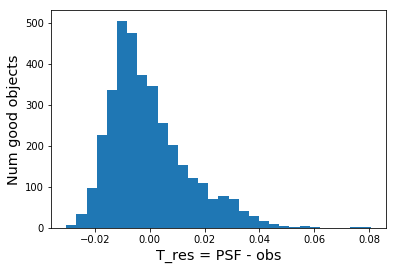

min and max mag:  20.0168380737 24.1336860657


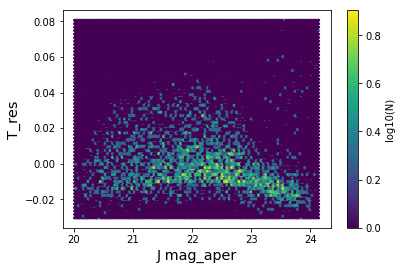

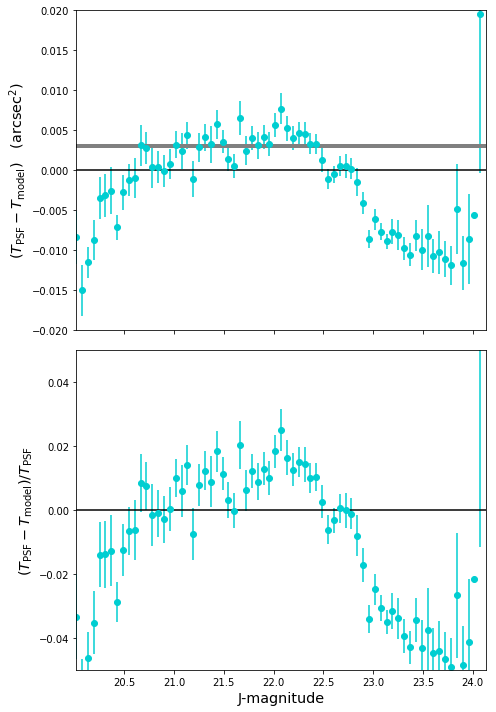

H
   found %d stars 281295 11820991
magaper
[[ 23.56775665  22.06742477  21.26314354 ...,  19.15787315  18.93605614
   18.88053131]
 [ 20.33840752  18.99317169  18.33631134 ...,  17.52726936  17.49807358
   17.48987961]
 [ 20.2983036   18.94140053  18.29665565 ...,  17.51760674  17.48937416
   17.49939728]
 ..., 
 [ 24.74599648  23.41403198  22.73188019 ...,  20.28017998  20.31557083
   20.23771095]
 [ 24.4589138   23.03929329  22.31679153 ...,  21.40816879  21.70594978
   22.82725334]
 [ 25.14193916  23.69850159  22.93878746 ...,  21.34087181  21.32645988
   21.08441353]]
(281295, 12)
   found %d good stars 281295


[array([ 150.00645085,  149.97192187,  150.06707224, ...,  149.83644985,
        150.0573953 ,  150.09155495]), array([ 1.58936332,  1.58960475,  1.58983391, ...,  2.83548135,
        2.83534987,  2.8353852 ])]
[ 150.00645085  149.97192187  150.06707224 ...,  149.83644985  150.0573953
  150.09155495]
final psfex_flag = %s [1 1 1 ..., 1 1 1]
['FLAGS_PSF', 'SOURCE_NUMBER', 'X_IMAGE', 'Y_IMAGE', 'mag_aper', 'flux_radius', 'use', 'obs_dx', 'obs_dy', 'obs_e1', 'obs_e2', 'obs_T', 'obs_flux', 'obs_flag', 'ra', 'dec', 'psfex_dx', 'psfex_dy', 'psfex_e1', 'psfex_e2', 'psfex_T', 'psfex_flux', 'psfex_flag']
FLAGS_PSF SOURCE_NUMBER    X_IMAGE    ... psfex_T psfex_flux psfex_flag
--------- ------------- ------------- ... ------- ---------- ----------
      112             1 25351.5296621 ...  -999.0     -999.0        129
       48             2 26179.9570673 ...  -999.0     -999.0        129
       48             3 23897.0898165 ...  -999.0     -999.0        129
       16             4 19363.8526353

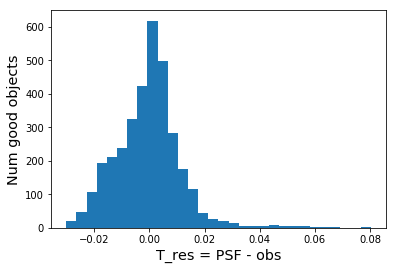

min and max mag:  19.8125171661 23.8735332489


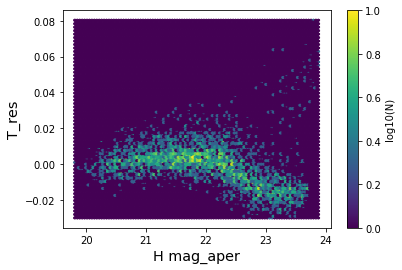

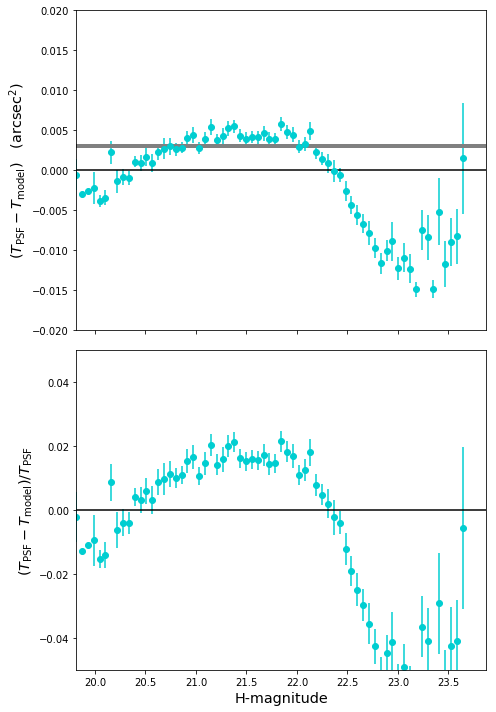

Ks
   found %d stars 243272 10177177
magaper
[[ 22.56864166  21.23214531  20.72441864 ...,  19.76487541  19.34680939
   19.46891022]
 [ 20.46394348  19.13623428  18.49073029 ...,  17.71387482  17.69616318
   17.67664719]
 [ 20.74816704  19.3817234   18.70298576 ...,  17.71576691  17.74677277
   17.73804474]
 ..., 
 [ 23.13713837  21.71914291  21.013937   ...,  19.26232338  19.24308586
   19.45886421]
 [ 24.13686752  22.74198151  22.02716064 ...,  20.73935509  20.37890625
   19.96479607]
 [ 24.49023819  23.09671593  22.3981781  ...,  20.78360558  20.33096695
   20.21705055]]
(243272, 12)
   found %d good stars 243272


[array([ 149.83825463,  149.97192544,  150.06706119, ...,  149.80771975,
        150.05740752,  150.09156952]), array([ 1.58920266,  1.58960798,  1.58983132, ...,  2.83528506,
        2.83531633,  2.83536907])]
[ 149.83825463  149.97192544  150.06706119 ...,  149.80771975  150.05740752
  150.09156952]
final psfex_flag = %s [1 1 1 ..., 1 1 1]
['FLAGS_PSF', 'SOURCE_NUMBER', 'X_IMAGE', 'Y_IMAGE', 'mag_aper', 'flux_radius', 'use', 'obs_dx', 'obs_dy', 'obs_e1', 'obs_e2', 'obs_T', 'obs_flux', 'obs_flag', 'ra', 'dec', 'psfex_dx', 'psfex_dy', 'psfex_e1', 'psfex_e2', 'psfex_T', 'psfex_flux', 'psfex_flag']
FLAGS_PSF SOURCE_NUMBER    X_IMAGE    ... psfex_T psfex_flux psfex_flag
--------- ------------- ------------- ... ------- ---------- ----------
      112             1 29386.9655433 ...  -999.0     -999.0        129
       48             2 26179.8715006 ...  -999.0     -999.0        129
       16             3 23897.3549244 ...  -999.0     -999.0        129
       16             4 29863.380274

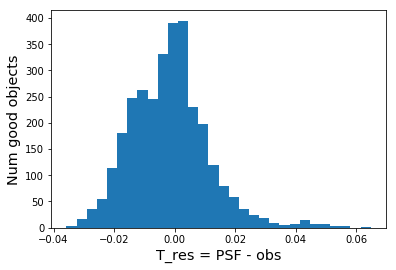

min and max mag:  19.3204994202 23.4142246246


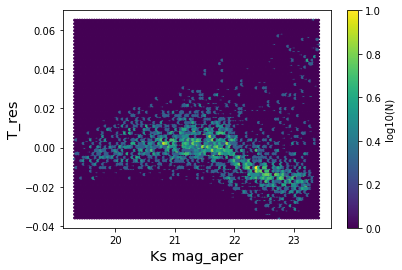

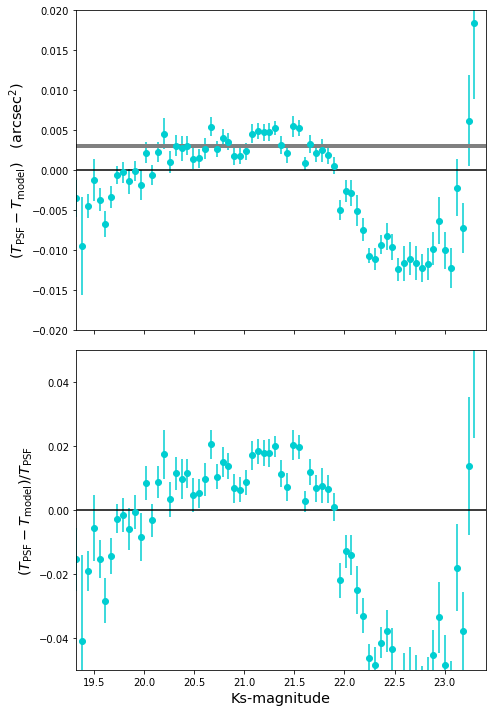

Y
   found %d stars 264247 11420349
magaper
[[ 22.26130295  20.80253983  20.00173378 ...,  18.65665245  18.48599434
   18.3073864 ]
 [ 22.5914669   20.97994614  20.12173271 ...,  18.90721321  18.87478828
   18.83658791]
 [ 23.65525436  22.30165482  21.67045021 ...,  20.85207748  20.72543526
   20.3410778 ]
 ..., 
 [ 23.73918533  22.21019173  21.32100296 ...,  18.62883949  18.18226433
   17.91585159]
 [ 25.44935036  23.99923134  23.2345829  ...,  21.95248985  21.5469799
   21.20549011]
 [ 25.69340515  24.26781845  23.48609161 ...,  21.7465744   22.09711266
   99.        ]]
(264247, 12)
   found %d good stars 264247


[array([ 149.82264319,  149.97193959,  149.81842711, ...,  150.24187703,
        150.05741539,  150.09157993]), array([ 1.58951748,  1.58971758,  1.58994332, ...,  2.83516463,
        2.83538598,  2.8353888 ])]
[ 149.82264319  149.97193959  149.81842711 ...,  150.24187703  150.05741539
  150.09157993]
final psfex_flag = %s [1 1 1 ..., 1 1 1]
['FLAGS_PSF', 'SOURCE_NUMBER', 'X_IMAGE', 'Y_IMAGE', 'mag_aper', 'flux_radius', 'use', 'obs_dx', 'obs_dy', 'obs_e1', 'obs_e2', 'obs_T', 'obs_flux', 'obs_flag', 'ra', 'dec', 'psfex_dx', 'psfex_dy', 'psfex_e1', 'psfex_e2', 'psfex_T', 'psfex_flux', 'psfex_flag']
FLAGS_PSF SOURCE_NUMBER    X_IMAGE    ... psfex_T psfex_flux psfex_flag
--------- ------------- ------------- ... ------- ---------- ----------
       16             1 29761.5251624 ...  -999.0     -999.0        129
       80             2  26179.531762 ...  -999.0     -999.0        129
       48             3 29862.6784759 ...  -999.0     -999.0        129
       48             4 17542.319154

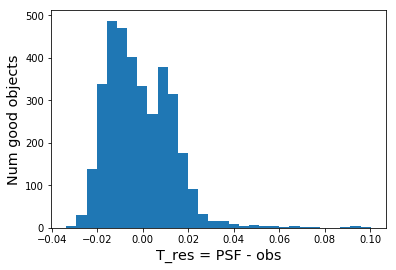

min and max mag:  20.3946685791 24.4603443146


ZeroDivisionError: float division by zero

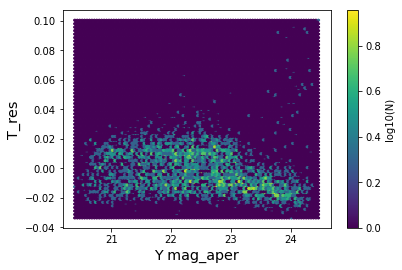

In [10]:
# Change locations to yours      
cdir = '/global/cscratch1/sd/aamon/DEEP/UVista'
cdir2= '/global/cscratch1/sd/amichoi/UltraVISTA'                                            

#band =  "J" #H, Ks, Y
bands=["J" , "H", "Ks", "Y"]

for band in bands:
    print(band)
    
    pf = '%s/psf/UVISTA_%s_21_01_16_psfcat.psf' % (cdir2, band) # PSFEx image
    sf= '%s/psf/UVISTA_%s_21_01_16_psfex-starlist.fits' % (cdir2, band) #list of stars made from Sextractor and PSFEx
    cf = '%s/cat/UVISTA_%s_21_01_16_psfcat.fits' % (cdir2, band) #the output from extractor 
    im_f = '%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.fits' % (cdir, band)  #VIDEO_H_10_34.31_-4.80.cleaned.fits
    wt_f = '%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.weight.fits'%(cdir, band)   

    full_image = galsim.fits.read(im_f, hdu=0)
    wcs = full_image.wcs

    magzp = 30.0
    mmlogging_level = logging.INFO
    logger = logging.getLogger('size_residual')
    # Read in some useful values, such as position                                                                           
    df = read_psfex_stars(sf, cf, magzp, logger)
    # Measure the hsm shapes on the stars in the actual image                                                                
    measure_star_shapes(
        df,im_f,noweight=False,wcs=wcs,logger=logger)
    # Measure                                                                                                                
    measure_psfex_shapes(
        df,pf,im_f,noweight=False,wcs=wcs,use_ngmix, fwhm, logger=logger)

    print(list(df))
    from astropy.table import Table
    t = Table.from_pandas(df)
    name='PSFres_UVISTA_%s.fits' % (band)
    t.write(name, overwrite=True)  
    print(t)
    
    ####################################################
    #CUTS
    print("All objs: ", len(df))
    good = (df['psfex_T'].values!=-999)&(df['obs_T'].values!=-999)
    df=df[good]
    print("Good objs: ", len(df))
    
    ####################################################
    #PLOT
    def compute_res(d):
        dt =  (d['obs_T']-d[prefix+'_T'])
        dtfrac = dt/d['obs_T']
        print('mean dt = ',np.mean(dt))
        return dtfrac, dt 

    prefix="psfex"
    fracsizeres, sizeres=compute_res(df)

    # Plotting the distribution of residuals                                                                                 
    plt.hist(sizeres, 30)
    plt.xlabel('T_res = PSF - obs', fontsize='x-large')
    plt.ylabel('Num good objects',fontsize='x-large')
    #plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
    plt.figure(figsize=(12,12))
    plt.show()

    fig, ax = plt.subplots()
    hb=ax.hexbin(df['mag_aper'],sizeres ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('log10(N)')
    plt.xlabel('%s mag_aper' %(band), fontsize='x-large')
    plt.ylabel('T_res', fontsize='x-large')
    #plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')

    bin_by_mag(df['mag_aper'], sizeres, fracsizeres, 15, band)


"""                                                                                                                      
Currently no functions to:     
- ngmix instead of hsm
 - remove bad stars (e.g. I didn't take this function from Mike's script)                                                
 - also didn't take flag_outliers function from his script, and this might                                               
   be useful(?)           
- is weight file working?
"""

In [ ]:
  # Starfile has the following columns:
    # id: The original id from the SExtractor catalog
    # x: The x position
    # y: The y position
    # sky: The local sky value
    # noise: The estimated noise.  But these are all 0, so I think this isn't being calculated.
    # size_flags: Error flags that occurred when estimating the size
    # mag: The magnitude from SExtractor
    # sg: SExtractor's star/galaxy estimate.  Currently SPREAD_MODEL.  (Actually, currently none)
    # sigma0: The shapelet sigma that results in a b_11 = 0 shapelet parameter.
    # star_flag: 1 if findstars thought this was a star, 0 otherwise.
    
    #psfcat has the following columns:
    # name = 'VIGNET'; format = '3969E'; unit = 'count'; disp = 'G12.7'; dim = '(63, 63)'
    # name = 'XWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    # name = 'YWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    # name = 'X_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    # name = 'Y_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    # name = 'FLUX_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    # name = 'FLUXERR_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    # name = 'FLUX_MAX'; format = '1E'; unit = 'count'; disp = 'G12.7'
    # name = 'MAG_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    # name = 'MAGERR_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    # name = 'FLUX_RADIUS'; format = '1E'; unit = 'pixel'; disp = 'F10.3'
    # name = 'ELONGATION'; format = '1E'; disp = 'F8.3'
    # name = 'FLAGS'; format = '1I'; disp = 'I3'
    # name = 'SNR_WIN'; format = '1E'; disp = 'G10.4'
    # name = 'ERRAWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    # name = 'ERRBWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    # name = 'ERRTHETAWIN_J2000'; format = '1E'; unit = 'deg'; disp = 'F6.2'

In [ ]:
# Now plot some results:                                                                                                 
print("All objs: ", len(df))
#good = (df['psfex_T'].values!=-999)&(df['obs_T'].values!=-999)
#df=df[good]
print("Good objs: ", len(df))
#resid_T = psf_t-star_t
#dtfrac = psf_t/star_t
#mag=df['mag_aper']#[good]

def compute_res(d):
    dt =  (d['obs_T']-d[prefix+'_T'])
    dtfrac = dt/d['obs_T']
    #print('mean dt = ',np.mean(dt))
    return dtfrac, dt 

prefix="psfex"
fracsizeres, sizeres=compute_res(df)

# Plotting the distribution of residuals                                                                                 
plt.hist(sizeres, 30)
plt.xlabel('T_res = PSF - obs', fontsize='x-large')
plt.ylabel('Num good objects',fontsize='x-large')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
plt.figure(figsize=(12,12))
plt.show()

fig, ax = plt.subplots()
hb=ax.hexbin(df['mag_aper'],sizeres ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.xlabel('mag_aper', fontsize='x-large')
plt.ylabel('T_res', fontsize='x-large')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')

bin_by_mag(df['mag_aper'], sizeres, fracsizeres, 15, band)
